# Experiment: Vary the duration of the $R_{ZX}$ pulse

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pprint

from qiskit import pulse, QuantumCircuit, QuantumRegister, transpile, IBMQ
from qiskit.circuit import Gate, Parameter
from qiskit.circuit.barrier import Barrier
from qiskit import schedule as build_schedule
from qiskit.ignis.verification.tomography import process_tomography_circuits
from qiskit.tools.monitor import job_monitor
from qiskit.visualization.pulse_v2 import IQXDebugging

from pulse_experiment_utils import *

IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='icepp')
backend = provider.get_backend('ibm_kawasaki')
#backend = provider.get_backend('ibmq_montreal')
#backend = provider.get_backend('ibmq_bogota')
#backend = provider.get_backend('ibmq_toronto')

In [3]:
control_qubit = 0
target_qubit = 1

backend_config = backend.configuration()
backend_defaults = backend.defaults()
dt = backend_config.dt
calibrations = backend_defaults.instruction_schedule_map

control_drive_channel = backend_config.drive(control_qubit)
target_drive_channel = backend_config.drive(target_qubit)
control_channel = backend_config.control((control_qubit, target_qubit))[0]

## Visualize the CR tones

CNOT schedule contains a phase shift + pi pulse on the control qubit, a pi/2 pulse on the target qubit, and a sequence corresponding to $R_{ZX}(\pi/2)$ (which is split into two $\pi/4$ echo sequences)

In [4]:
cx_schedule = calibrations.get('cx', [control_qubit, target_qubit])

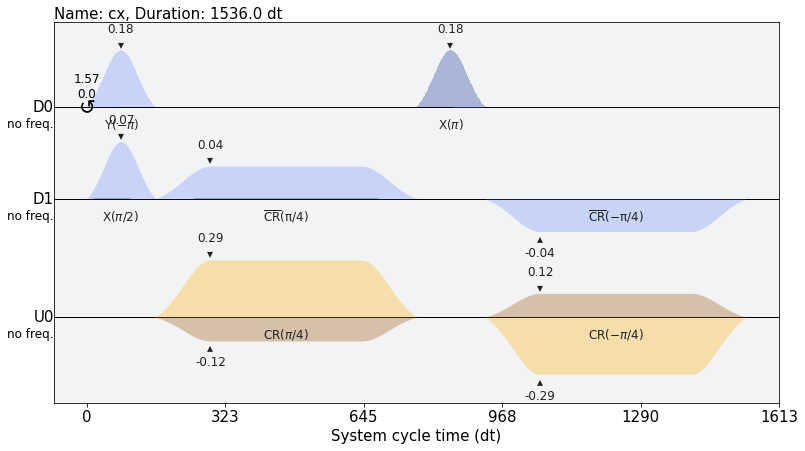

In [5]:
cx_schedule.draw(style=IQXDebugging())

## Define the circuits with varying duration of the GaussianSquare pulses

In [6]:
cx_dict = dict((inst[1].name, inst[1].pulse) for inst in cx_schedule.instructions if inst[1].name)

circuits = []

for duration_scale in [0.5, 0.75, 1.]:
    with pulse.build(backend=backend, default_alignment='sequential') as cr_sched:
        pulse.play(cx_dict['Xp_d0'], control_drive_channel)

        with pulse.align_left():
            p = cx_dict['CR90p_d1_u0']
            duration = get_closest_multiple_of_16(p.duration * duration_scale)
            width = p.width - (p.duration - duration)
            pulse.play(pulse.GaussianSquare(duration=duration, amp=p.amp, sigma=p.sigma, width=width, name=p.name), target_drive_channel)
            p = cx_dict['CR90p_u0']
            pulse.play(pulse.GaussianSquare(duration=duration, amp=p.amp, sigma=p.sigma, width=width, name=p.name), control_channel)
            
        pulse.play(cx_dict['Xp_d0'], control_drive_channel)
        
        with pulse.align_left():
            p = cx_dict['CR90m_d1_u0']
            duration = get_closest_multiple_of_16(p.duration * duration_scale)
            width = p.width - (p.duration - duration)
            pulse.play(pulse.GaussianSquare(duration=duration, amp=p.amp, sigma=p.sigma, width=width, name=p.name), target_drive_channel)
            p = cx_dict['CR90m_u0']
            pulse.play(pulse.GaussianSquare(duration=duration, amp=p.amp, sigma=p.sigma, width=width, name=p.name), control_channel)

    cr_gate = Gate('cr_gate', 2, [])
    
    z_circuit = QuantumCircuit(2, 2)
    z_circuit.append(cr_gate, (0, 1))
    z_circuit.measure_all()
    z_circuit.add_calibration('cr_gate', (0, 1), cr_sched)
    
    circuits.append(transpile(z_circuit, backend=backend))
    
    y_circuit = QuantumCircuit(2, 2)
    y_circuit.append(cr_gate, (0, 1))
    y_circuit.sx(1)
    y_circuit.measure_all()
    y_circuit.add_calibration('cr_gate', (0, 1), cr_sched)
    
    circuits.append(transpile(y_circuit, backend=backend))

In [7]:
pprint.pprint(cr_sched.instructions)

((0,
  Play(Drag(duration=160, amp=(0.18080376134663848+0j), sigma=40, beta=-1.0638507313367476, name='Xp_d0'), DriveChannel(0), name='Xp_d0')),
 (160,
  Play(GaussianSquare(duration=608, amp=(0.04200282919689204+0.00047595233525180947j), sigma=64, width=352, name='CR90p_d1_u0'), DriveChannel(1), name='CR90p_d1_u0')),
 (160,
  Play(GaussianSquare(duration=608, amp=(0.2877486222882762-0.12004180748886886j), sigma=64, width=352, name='CR90p_u0'), ControlChannel(0), name='CR90p_u0')),
 (768,
  Play(Drag(duration=160, amp=(0.18080376134663848+0j), sigma=40, beta=-1.0638507313367476, name='Xp_d0'), DriveChannel(0), name='Xp_d0')),
 (928,
  Play(GaussianSquare(duration=608, amp=(-0.04200282919689204-0.0004759523352518043j), sigma=64, width=352, name='CR90m_d1_u0'), DriveChannel(1), name='CR90m_d1_u0')),
 (928,
  Play(GaussianSquare(duration=608, amp=(-0.2877486222882762+0.1200418074888689j), sigma=64, width=352, name='CR90m_u0'), ControlChannel(0), name='CR90m_u0')))


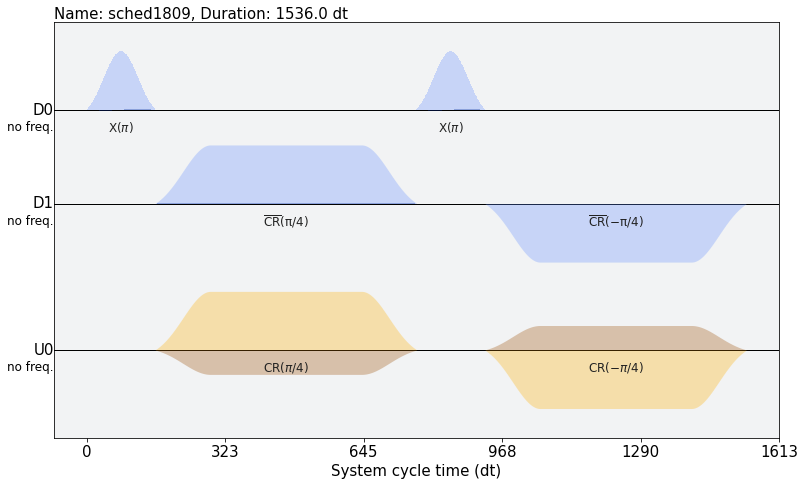

In [8]:
cr_sched.draw()

## Execute the circuits and plot $\langle Y \rangle$ and $\langle Z \rangle$ of the target qubit

In [9]:
if False:
    job = backend.run(circuits, shots=2048)
    print(job.job_id())
    job_monitor(job)
else:
    job = backend.retrieve_job('6140378c744103a1f232bbdc')

In [10]:
result = job.result()

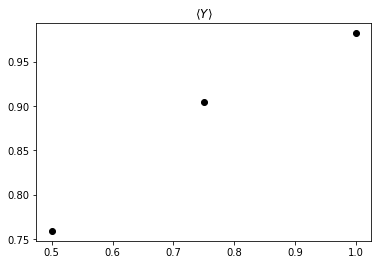

In [11]:
plot_counts(result, ['00 00', '01 00'], x=np.array([0.5, 0.75, 1.]), indices=[1, 3, 5], title=r'$\langle Y \rangle$')

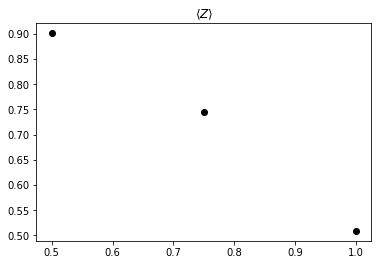

In [12]:
plot_counts(result, ['00 00', '01 00'], x=np.array([0.5, 0.75, 1.]), indices=[0, 2, 4], title=r'$\langle Z \rangle$')